<a href="https://colab.research.google.com/github/miapienkowski/cs254FinalProject/blob/Mia/cs254march19.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

CS254 Code for Project Proposal 03/19
Mia Pienkowski

In [ ]:
from pycocotools.coco import COCO
import numpy as np
import skimage.io as io
import random
import os
import cv2
import tensorflow as tf
from tensorflow.keras import datasets, layers, models
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
%matplotlib inline


In [ ]:
#import data from git repository
!git clone https://github.com/miapienkowski/cs254FinalProject.git

Cloning into 'cs254FinalProject'...
remote: Enumerating objects: 17951, done.
remote: Total 17951 (delta 0), reused 0 (delta 0), pack-reused 17951
Receiving objects: 100% (17951/17951), 546.94 MiB | 25.20 MiB/s, done.
Resolving deltas: 100% (2167/2167), done.
Checking out files: 100% (3731/3731), done.


# Defining Functions

In [ ]:
#filterDataset processes data

#mode train or validating or testing
def filterDataset(folder, classes=None, mode='train'):    
    # initialize COCO api for instance annotations
    annFile = '{}/{}val.json'.format(folder, mode)
    coco = COCO(annFile)
    
    images = []
    if classes!=None:
        # iterate for each individual class in the list
        for className in classes:
            # get all images containing given categories
            catIds = coco.getCatIds(catNms=className)
            imgIds = coco.getImgIds(catIds=catIds)
            images += coco.loadImgs(imgIds)
    
    else:
        imgIds = coco.getImgIds()
        images = coco.loadImgs(imgIds)
    
    # Now, filter out the repeated images
    unique_images = []
    for i in range(len(images)):
        if images[i] not in unique_images:
            unique_images.append(images[i])
            
    random.shuffle(unique_images)
    dataset_size = len(unique_images)
    
    return unique_images, dataset_size, coco

In [ ]:
#image processeing
def getImage(imageObj, img_folder, input_image_size):
    # Read and normalize an image
    train_img = io.imread(img_folder + '/' + imageObj['file_name'])/255.0
    # Resize
    train_img = cv2.resize(train_img, input_image_size)
    if (len(train_img.shape)==3 and train_img.shape[2]==3): # If it is a RGB 3 channel image
        return train_img
    else: # To handle a black and white image, increase dimensions to 3
        stacked_img = np.stack((train_img,)*3, axis=-1)
        return stacked_img

#normal mask : 2-channel semantic segmentation mask with dimensions equal to the original image    
def getNormalMask(imageObj, classes, coco, catIds, input_image_size):
    annIds = coco.getAnnIds(imageObj['id'], catIds=catIds, iscrowd=None)
    anns = coco.loadAnns(annIds)
    cats = coco.loadCats(catIds)
    train_mask = np.zeros(input_image_size)
    for a in range(len(anns)):
        className = getClassName(anns[a]['category_id'], cats)
        pixel_value = classes.index(className)+1
        new_mask = cv2.resize(coco.annToMask(anns[a])*pixel_value, input_image_size)
        train_mask = np.maximum(new_mask, train_mask)

    # Add extra dimension for parity with train_img size [X * X * 3]
    train_mask = train_mask.reshape(input_image_size[0], input_image_size[1], 1)
    return train_mask  
#binary mask: 2 pixel values- 1 (object: could be any of the N classes) and 0 (the background)   
def getBinaryMask(imageObj, coco, catIds, input_image_size):
    annIds = coco.getAnnIds(imageObj['id'], catIds=catIds, iscrowd=None)
    anns = coco.loadAnns(annIds)
    train_mask = np.zeros(input_image_size)
    for a in range(len(anns)):
        new_mask = cv2.resize(coco.annToMask(anns[a]), input_image_size)
        
        #Threshold because resizing may cause extraneous values
        new_mask[new_mask >= 0.5] = 1
        new_mask[new_mask < 0.5] = 0

        train_mask = np.maximum(new_mask, train_mask)

    # Add extra dimension for parity with train_img size [X * X * 3]
    train_mask = train_mask.reshape(input_image_size[0], input_image_size[1], 1)
    return train_mask

In [ ]:
#builds generator type object
#performs batch-sized loops [lines 20~] and retrieves the image from the folder,
# loads the mask with the filtered outputs (binary or normal segmentation masks), 
# lumps them to form an image batch and mask batch

def dataGeneratorCoco(images, classes, coco, folder, 
                      input_image_size=(224,224), batch_size=4, mode='train', mask_type='binary'):
    

    img_folder = '{}/data'.format(folder)
    dataset_size = len(images)
    catIds = coco.getCatIds(catNms=classes)
    
    c = 0
    while(True):
        img = np.zeros((batch_size, input_image_size[0], input_image_size[1], 3)).astype('float')
        mask = np.zeros((batch_size, input_image_size[0], input_image_size[1], 1)).astype('float')

        for i in range(c, c+batch_size): #initially from 0 to batch_size, when c = 0
            imageObj = images[i]
            
            ### Retrieve Image ###
            train_img = getImage(imageObj, img_folder, input_image_size)
            
            ### Create Mask ###
            if mask_type=="binary":
                train_mask = getBinaryMask(imageObj, coco, catIds, input_image_size)
            
            elif mask_type=="normal":
                train_mask = getNormalMask(imageObj, classes, coco, catIds, input_image_size)                
            
            # Add to respective batch sized arrays
            img[i-c] = train_img
            mask[i-c] = train_mask
            
        c+=batch_size
        if(c + batch_size >= dataset_size):
            c=0
            random.shuffle(images)
        yield img, mask

In [ ]:
#visualize the generator objects
def visualizeGenerator(gen):
    # Iterate the generator to get image and mask batches
    img, mask = next(gen)
 
    fig = plt.figure(figsize=(20, 10))
    outerGrid = gridspec.GridSpec(1, 2, wspace=0.1, hspace=0.1)
   
    for i in range(2):        
        innerGrid = gridspec.GridSpecFromSubplotSpec(2, 2, subplot_spec=outerGrid[i], wspace=0.05, hspace=0.05)

        for j in range(4):
            ax = plt.Subplot(fig, innerGrid[j])
            if(i==1):
                ax.imshow(img[j]);
            else:
                ax.imshow(mask[j][:,:,0]);
                
            ax.axis('off')
            fig.add_subplot(ax)
    plt.show()

# End Functions

In [ ]:
#get processed validating data
#validating
val_folder = 'cs254FinalProject/validatingDirectory'
val_classes = ['cable', 'tower_lattice', 'tower_tuchoy','tower_wooden']
val_mode = 'validating'

val_images, val_dataset_size, val_coco = filterDataset(val_folder, val_classes, val_mode)

loading annotations into memory...
Done (t=0.02s)
creating index...
index created!


In [ ]:
#get processed training data
#training
train_folder = 'cs254FinalProject/trainingDirectory'
train_classes = ['cable', 'tower_lattice', 'tower_tuchoy','tower_wooden']
train_mode = 'train'

train_images, train_dataset_size, train_coco = filterDataset(train_folder, train_classes, train_mode)

loading annotations into memory...
Done (t=0.27s)
creating index...
index created!


In [ ]:
#creates a data generator object yielding batches of images and binary mask
#val
batch_size = 4
input_image_size = (700,700)
mask_type = 'binary'

val_gen = dataGeneratorCoco(val_images, val_classes, val_coco, val_folder, 
                            input_image_size, batch_size, val_mode, mask_type)

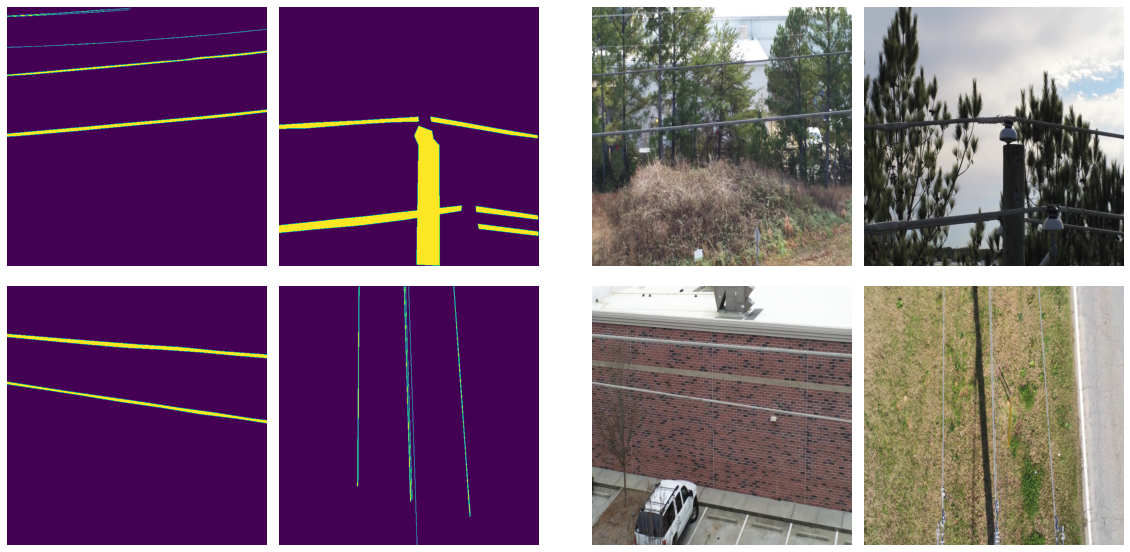

In [ ]:
visualizeGenerator(val_gen)

In [ ]:
#creates a data generator object yielding batches of images and binary mask
#train
batch_size = 4
input_image_size = (700,700)
mask_type = 'binary'

train_gen = dataGeneratorCoco(train_images, train_classes, train_coco, train_folder, 
                            input_image_size, batch_size, train_mode, mask_type)

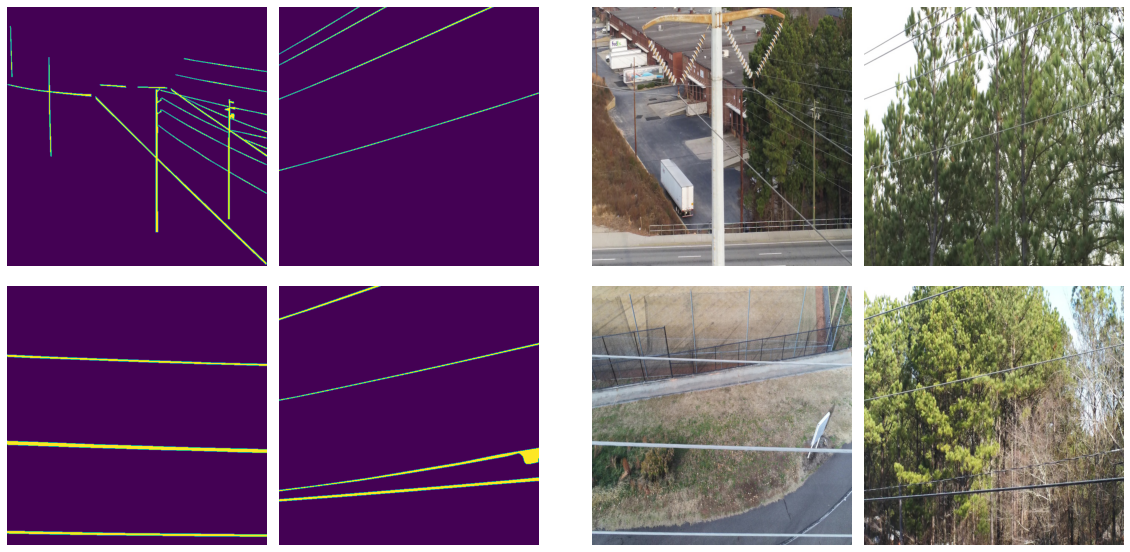

In [ ]:
visualizeGenerator(train_gen)

Create model object

In [ ]:
model = models.Sequential()
model.add(layers.Conv2D(32, (3, 3), activation='relu', input_shape=(700, 700, 3)))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(64, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(64, (3, 3), activation='relu'))

In [ ]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 698, 698, 32)      896       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 349, 349, 32)      0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 347, 347, 64)      18496     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 173, 173, 64)      0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 171, 171, 64)      36928     
Total params: 56,320
Trainable params: 56,320
Non-trainable params: 0
_________________________________________________________________


In [ ]:
model.add(layers.Flatten())
model.add(layers.Dense(64, activation='relu'))
model.add(layers.Dense(10))

In [ ]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 698, 698, 32)      896       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 349, 349, 32)      0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 347, 347, 64)      18496     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 173, 173, 64)      0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 171, 171, 64)      36928     
_________________________________________________________________
flatten (Flatten)            (None, 1871424)           0         
_________________________________________________________________
dense (Dense)                (None, 64)                1

In [ ]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

End Model Building

Start Training

In [ ]:
n_epochs = 10
steps_per_epoch = train_dataset_size// batch_size
validation_steps = val_dataset_size // batch_size

Trying out different things...
the issue is there is not just one label for each image, since were detecting/classifying objects within images...and I think the CNN code is just classifying individual images

In [ ]:
val_annIds = val_coco.getAnnIds()
val_anns = val_coco.loadAnns(val_annIds)
train_annIds = train_coco.getAnnIds() 
train_anns = train_coco.loadAnns(train_annIds)

In [ ]:
history = model.fit(train_images, train_anns, epochs=10, 
                    validation_data=(val_images, val_anns))

ValueError: ignored

##GETTING ERROR - wrong dimensions somewhere

In [ ]:
# Start the training process
history = model.fit(x = train_gen,
                validation_data = val_gen,
                #steps_per_epoch = steps_per_epoch,
                #validation_steps = validation_steps,
                epochs = n_epochs,
                verbose=True)

Epoch 1/10


InvalidArgumentError: ignored

Evaluation